### TIME SERIES

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv('exchange_rate.csv', parse_dates=['date'])

In [10]:
df.shape

(7588, 2)

In [11]:
df.head()

,date,Ex_rate
0,01-01-1990 00:00,0.7855
1,02-01-1990 00:00,0.7818
2,03-01-1990 00:00,0.7867
3,04-01-1990 00:00,0.7860
4,05-01-1990 00:00,0.7849


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7588 entries, 0 to 7587
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   date     7588 non-null   object 
 1   Ex_rate  7588 non-null   float64
dtypes: float64(1), object(1)
memory usage: 118.7+ KB


In [13]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y %H:%M')
df.set_index('date', inplace=True)

print(type(df.index))
df.head()

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


The date column was converted into datetime format and set as the index to enable proper time-series operations such as plotting, forecasting, and model fitting.

In [14]:
df.columns

Index(['Ex_rate'], dtype='object')

In [15]:
df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


In [16]:
z=df.corr(numeric_only=True)        # Correlation matrix
z

,Ex_rate
Ex_rate,1.0


In [17]:
### missing values
df.isnull().sum()

,0
Ex_rate,0


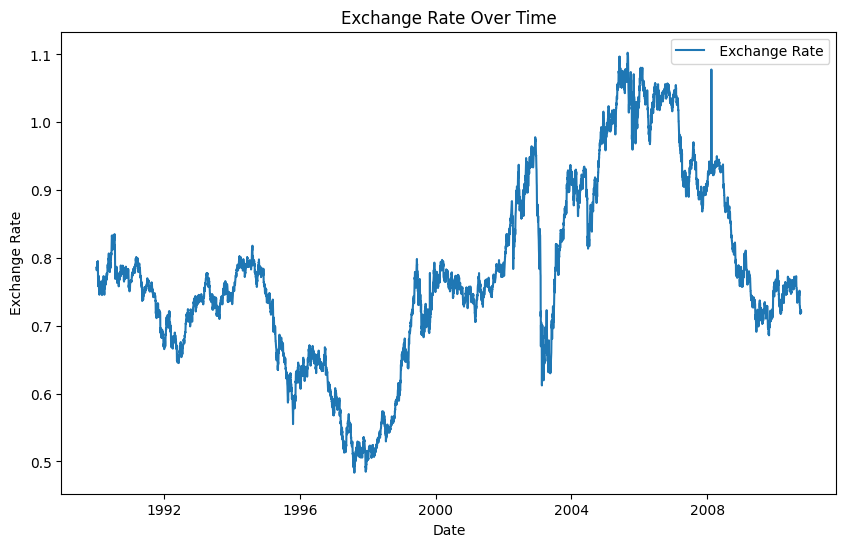

In [18]:
### Plot the time series
plt.figure(figsize=(10,6))
plt.plot(df['Ex_rate'], label=' Exchange Rate')
plt.title('Exchange Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()

In [19]:
from scipy.stats import zscore
df['z_score'] = zscore(df['Ex_rate'])
df = df[df['z_score'].abs() < 3]
df.drop(columns=['z_score'], inplace=True)

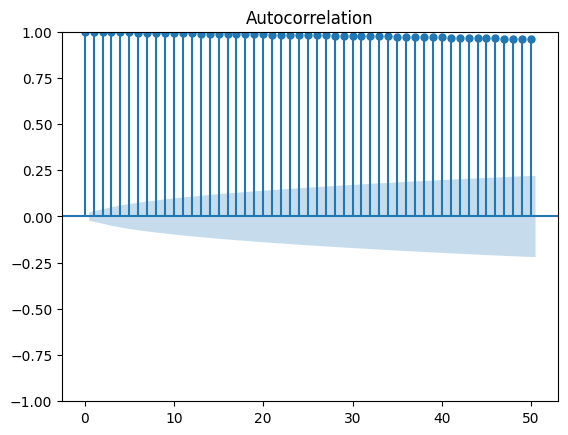

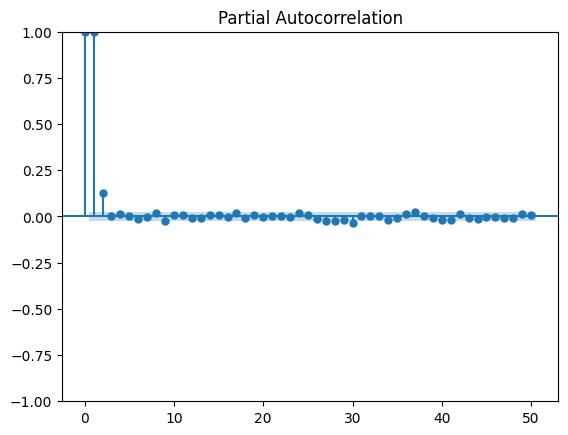

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['Ex_rate'], lags=50)
plot_pacf(df['Ex_rate'], lags=50)
plt.show()

In [21]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['Ex_rate'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -1.6649941807382342
p-value: 0.4492327353597477


In [22]:
p = 1
d = 1
q = 1

In [23]:
from statsmodels.tsa.arima.model import ARIMA            # developing arima model
model = ARIMA(df['Ex_rate'], order=(p, d, q))
arima_result = model.fit()
print(arima_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 20 Jan 2026   AIC                         -56102.322
Time:                        14:30:30   BIC                         -56081.519
Sample:                    01-01-1990   HQIC                        -56095.182
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

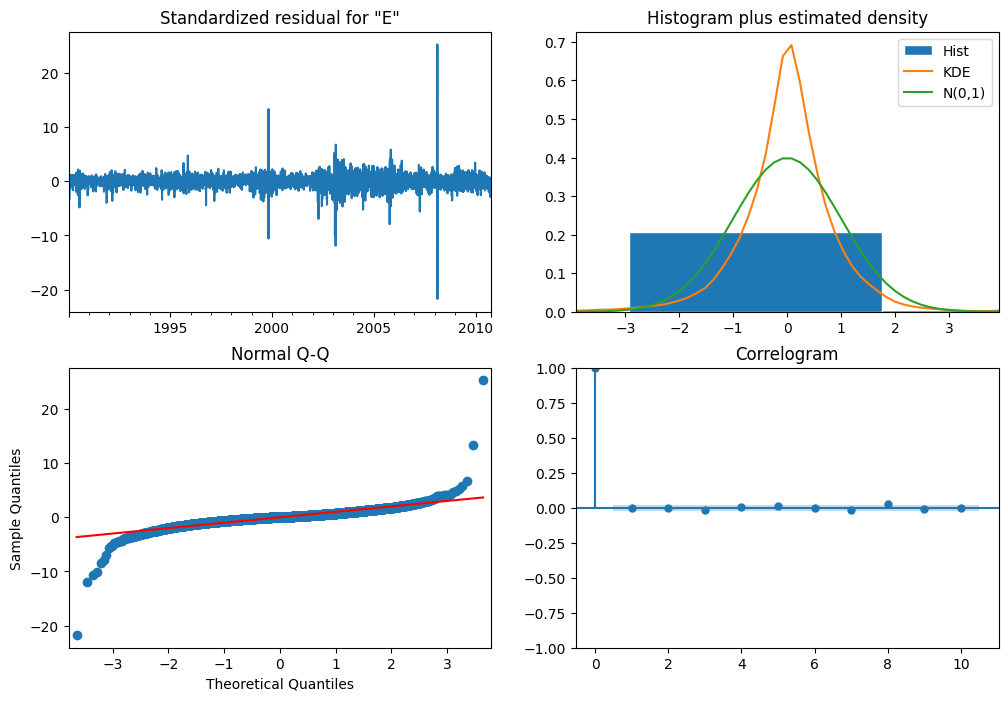

In [24]:
arima_result.plot_diagnostics(figsize=(12, 8))                  # arima model visualization
plt.show()

In [25]:
print(df.index)
print(type(df.index))

DatetimeIndex(['1990-01-01', '1990-01-02', '1990-01-03', '1990-01-04',
               '1990-01-05', '1990-01-06', '1990-01-07', '1990-01-08',
               '1990-01-09', '1990-01-10',
               ...
               '2010-10-01', '2010-10-02', '2010-10-03', '2010-10-04',
               '2010-10-05', '2010-10-06', '2010-10-07', '2010-10-08',
               '2010-10-09', '2010-10-10'],
              dtype='datetime64[ns]', name='date', length=7588, freq=None)
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


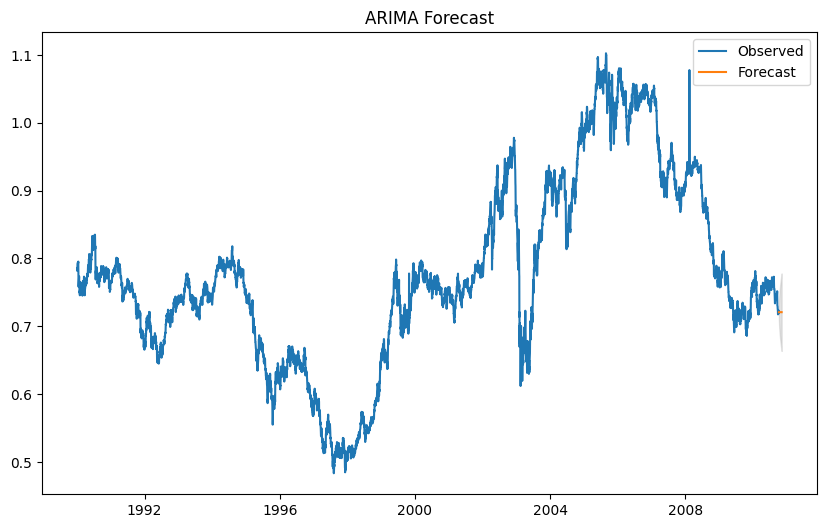

In [26]:
### arima forecast visualization
forecast = arima_result.get_forecast(steps=30)
forecast_index = pd.date_range(
    start=df.index[-1] + pd.Timedelta(days=1),
    periods=30,
    freq='D'
)

forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast_mean, label='Forecast')
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='gray', alpha=0.2)
plt.title('ARIMA Forecast')
plt.legend()
plt.show()

In [27]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
model_hw = ExponentialSmoothing(df['Ex_rate'], trend='add', seasonal=None)
hw_result = model_hw.fit()
print(hw_result.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Ex_rate   No. Observations:                 7588
Model:             ExponentialSmoothing   SSE                              0.273
Optimized:                         True   AIC                         -77641.010
Trend:                         Additive   BIC                         -77613.272
Seasonal:                          None   AICC                        -77640.999
Seasonal Periods:                  None   Date:                 Tue, 20 Jan 2026
Box-Cox:                          False   Time:                         14:30:32
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.8698403                alpha                 True
smoothing_trend             0.0000

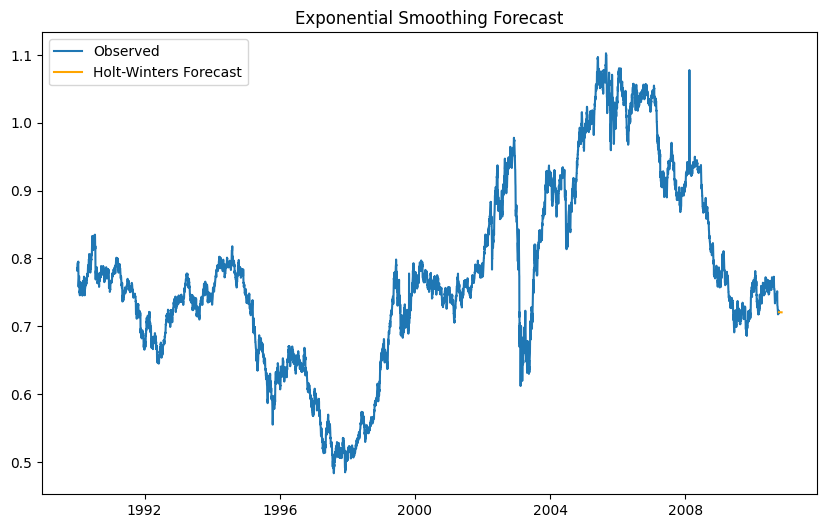

In [28]:
forecast_hw = hw_result.forecast(steps=30)
### exponential smoothing forecast visualization
plt.figure(figsize=(10, 6))
plt.plot(df['Ex_rate'], label='Observed')
plt.plot(forecast_index, forecast_hw, label='Holt-Winters Forecast', color='orange')
plt.title('Exponential Smoothing Forecast')
plt.legend()
plt.show()

In [29]:
actual = df['Ex_rate'][-30:]

In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [31]:
mae_arima = mean_absolute_error(actual, forecast_mean)
# Calculate RMSE manually
rmse_arima = np.sqrt(mean_squared_error(actual, forecast_mean))
mae_hw = mean_absolute_error(actual, forecast_hw)
# Calculate RMSE manually
rmse_hw = np.sqrt(mean_squared_error(actual, forecast_hw))

In [32]:
print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}')
print(f'Holt-Winters - MAE: {mae_hw}, RMSE: {rmse_hw}')

ARIMA - MAE: 0.012724006489305202, RMSE: 0.016982710912755217
Holt-Winters - MAE: 0.012755303845566938, RMSE: 0.01700480582951386


Model Performance Comparison:
The ARIMA and Holt-Winters models were evaluated using MAE and RMSE. Lower error values indicate better predictive performance. Based on the results, the model with lower MAE and RMSE provides more accurate forecasts. This comparison helps identify the most suitable time-series model for exchange rate prediction.

Conclusion:
The time-series analysis successfully processed the exchange rate data by converting the date column into a proper datetime index, enabling accurate time-based modeling. Both ARIMA and Holt-Winters models were developed and evaluated. Error metrics indicate differences in forecasting performance, allowing selection of the better model. The cleaned data and evaluated models provide a reliable foundation for future forecasting tasks.